# 1. RGB Rendering

In [44]:
import blosc
import gym
from gym_minigrid.window import Window
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
import torch

In [ ]:
# Load environment
level_name = "BossLevel"
env_name = f"BabyAI-{level_name}-v0"
env = gym.make(env_name)
_ = env.reset()

# Load generated demonstrations
with open(f"../../babyai/demos/{env_name}_valid.pkl", "rb") as f:
    demos = pkl.load(f)

In [127]:
mission, obs, grid_rgb, grid_raw, direction, action = demos[0]
obs = blosc.unpack_array(obs)
grid = blosc.unpack_array(grid_rgb)
print(mission)
print(grid.shape)

go to a red ball and pick up the red key
(96, 704, 704, 3)


In [111]:
obs_decoded, vis_mask = env.grid.decode(obs[0])
obs_rgb = obs_decoded.render(tile_size=32)

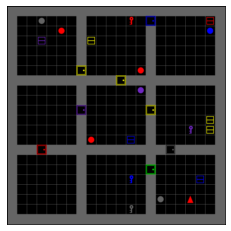

In [133]:
window = Window('gym_minigrid - ' + level_name)
window.show_img(grid[0])

# 2. 36-way Region Classification Data Generation

In [3]:
import blosc
import gym
from gym_minigrid.window import Window
import io
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
from PIL import Image
import torch
from tqdm import tqdm

In [4]:
# Load generated demonstrations from GoToObj
with open("../../demos/GoToObj.pkl", "rb") as f:
    demos_train = pkl.load(f)
    
with open("../../demos/GoToObj_valid.pkl", "rb") as f:
    demos_valid = pkl.load(f)

In [5]:
def get_region_cls_data(demos, object_idx_list=[5, 6, 7]):
    
    def get_object_coordinate(grid):
        # Get the labels of coordinates of the target ball
        # In GoToObj, objects can be key (5), ball (6), box (7)
        height, width, channel = grid.shape
        for h in range(height):
            for w in range(width):
                if grid[h][w][0] in object_idx_list:
                    return (h, w)
    
    def image_to_bytes(image):
        bytes_io = io.BytesIO()
        image.save(bytes_io, "PNG")
        return bytes_io.getvalue()
    
    def coordinate_to_label(coord):
        x, y = coord
        return ((x - 1) * 6 + y) - 1
        
    data = []
    for demo in tqdm(demos):
        _, _, grid_rgb, grid_raw, _, _ = demo
        grid_rgb = blosc.unpack_array(grid_rgb)
        grid_rgb = grid_rgb[0]  # Naively get the first state
        img = Image.fromarray(grid_rgb)
        img_encoded = image_to_bytes(img)
        
        grid_raw = blosc.unpack_array(grid_raw)
        grid_raw = grid_raw[0]  # Naively get the first state
        
        label = get_object_coordinate(grid_raw)
        label = coordinate_to_label(label)
        
        data.append({
            "img": img_encoded,
            "label": label
        })
    return data

In [53]:
data_train = get_region_cls_data(demos_train)
data_valid = get_region_cls_data(demos_valid)


100%|████████████████████████████████████████| 512/512 [00:01<00:00, 270.51it/s]


In [54]:
with open(f"../../data/babyai/region_cls_train.pkl", "wb") as f:
    pkl.dump(data_train, f)

with open(f"../../data/babyai/region_cls_valid.pkl", "wb") as f:
    pkl.dump(data_valid, f)

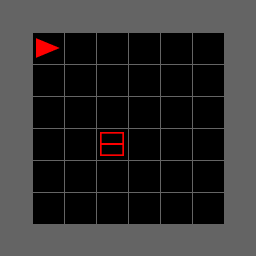

In [56]:
img_encoded = data_train[3]["img"]
Image.open(io.BytesIO(img_encoded))

In [79]:
temp = Image.open(io.BytesIO(img_encoded))
temp.size

(256, 256)

# 3. Generate Pretraining Data

In [1]:
import blosc
from collections import defaultdict
import io
import os
import pickle as pkl
from PIL import Image
from tqdm import tqdm

In [ ]:
level_name = "BossLevel"
with open(f"../../data/babyai_pretraining/BabyAI-{level_name}-v0.pkl", "rb") as f:
    demos_train = pkl.load(f)

with open(f"../../data/babyai_pretraining/BabyAI-{level_name}-v0_valid.pkl", "rb") as f:
    demos_valid = pkl.load(f)

print("train: ", len(demos_train))
print("valid: ", len(demos_valid))

In [6]:
def get_pretraining_data(
    env,
    data,
    output_dir_path,
    is_train,
    split_size=100,
    split_start_id=0,
):
    def image_to_bytes(image):
        bytes_io = io.BytesIO()
        image.save(bytes_io, "PNG")
        return bytes_io.getvalue()
    
    output_dir = os.path.join(output_dir_path, env)
    os.makedirs(output_dir, exist_ok=True)
    
    split_id = 0
    data_split = []
    for ex_id, ex in tqdm(enumerate(data), total=len(data)):
        img = blosc.unpack_array(ex[2])
        img = Image.fromarray(img[0])  # Always select the first frame
        img_encoded = image_to_bytes(img)
        #data_split["img"].append(img[0])  # Always select the first frame
        
        #data_split["mission"].append(ex[0])

        action = ",".join(ex[6])
        #data_split["action_seq"].append(action)
        data_split.append({
            "img": img_encoded,
            "mission": ex[0],
            "action_seq": action
        })
        
        if (ex_id+1) % split_size == 0:
            if is_train:
                output_name = f"split_train_{split_start_id + split_id}"
            else:
                output_name = f"split_valid_{split_start_id + split_id}"
            
            output_path = os.path.join(output_dir, f"{output_name}.pkl")
            with open(output_path, "wb") as f:
                pkl.dump(data_split, f)
            data_split = []
            split_id += 1
            #print("inside loop")
            #print("split_id:",split_id)
            #print("split_start_id:", split_start_id)
    
    if data_split:
        if is_train:
            output_name = f"split_train_{split_start_id + split_id}"
        else:
            output_name = f"split_valid_{split_start_id + split_id}"

        output_path = os.path.join(output_dir, f"{output_name}.pkl")
        with open(output_path, "wb") as f:
            pkl.dump(data_split, f)
        #print("if statement")
        #print("split_id:",split_id)
        #print("split_start_id:", split_start_id)
    
    return split_start_id + split_id  # used to track next starting splid_id

In [2]:
# No split size
def get_pretraining_data(
    env,
    data,
    output_dir_path,
    is_train,
    split_id,
):
    def image_to_bytes(image):
        bytes_io = io.BytesIO()
        image.save(bytes_io, "PNG")
        return bytes_io.getvalue()
    
    output_dir = os.path.join(output_dir_path, env)
    os.makedirs(output_dir, exist_ok=True)
    
    data_split = []
    for ex_id, ex in tqdm(enumerate(data), total=len(data)):
        img = blosc.unpack_array(ex[2])
        img = Image.fromarray(img[0])  # Always select the first frame
        img_encoded = image_to_bytes(img)
        
        action = ",".join(ex[6])
        
        data_split.append({
            "img": img_encoded,
            "mission": ex[0],
            "action_seq": action
        })
    
    if data_split:
        if is_train:
            output_name = f"split_train_{split_id}"
        else:
            output_name = f"split_valid_{split_id}"

        output_path = os.path.join(output_dir, f"{output_name}.pkl")
        with open(output_path, "wb") as f:
            pkl.dump(data_split, f)


In [3]:
level_name = "BossLevel"

split_start_id = 0

#for split_id in range(10):
for split_id in range(6, 10, 1):
    print(split_id)
    with open(f"../../data/babyai_pretraining/BabyAI-{level_name}-v0-split-{split_id}.pkl", "rb") as f:
        demos_train = pkl.load(f)
    
    split_start_id = get_pretraining_data(
        level_name, 
        demos_train, 
        output_dir_path="../../data/babyai_pretraining",
        is_train=True,
        #split_size=10000,
        split_id=split_id,
    )

6


100%|█████████████████████████████████████| 10000/10000 [17:29<00:00,  9.53it/s]


7


100%|█████████████████████████████████████| 10000/10000 [09:20<00:00, 17.83it/s]


8


100%|█████████████████████████████████████| 10000/10000 [09:22<00:00, 17.78it/s]


9


100%|█████████████████████████████████████| 10000/10000 [09:22<00:00, 17.78it/s]


In [4]:
level_name = "BossLevel"

split_start_id = 0

for split_id in range(10):
    print(split_id)
    with open(f"../../data/babyai_pretraining/BabyAI-{level_name}-v0-split-{split_id}_valid.pkl", "rb") as f:
        demos_valid = pkl.load(f)
    
    split_start_id = get_pretraining_data(
        level_name, 
        demos_valid, 
        output_dir_path="../../data/babyai_pretraining",
        is_train=False,
        split_id=split_id
    )

0


100%|█████████████████████████████████████████| 500/500 [00:28<00:00, 17.80it/s]


1


100%|█████████████████████████████████████████| 500/500 [00:27<00:00, 18.03it/s]


2


100%|█████████████████████████████████████████| 500/500 [00:27<00:00, 18.31it/s]


3


100%|█████████████████████████████████████████| 500/500 [00:28<00:00, 17.85it/s]


4


100%|█████████████████████████████████████████| 500/500 [00:27<00:00, 18.31it/s]


5


100%|█████████████████████████████████████████| 500/500 [00:28<00:00, 17.48it/s]


6


100%|█████████████████████████████████████████| 500/500 [00:28<00:00, 17.37it/s]


7


100%|█████████████████████████████████████████| 500/500 [00:29<00:00, 16.72it/s]


8


100%|█████████████████████████████████████████| 500/500 [00:28<00:00, 17.40it/s]


9


100%|█████████████████████████████████████████| 500/500 [00:26<00:00, 18.64it/s]


In [9]:
with open(f"../../data/babyai_pretraining/BabyAI-{level_name}-v0-split-0_valid.pkl", "rb") as f:
    data1 = pkl.load(f)

with open(f"../../data/babyai_pretraining/BabyAI-{level_name}-v0-split-1_valid.pkl", "rb") as f:
    data2 = pkl.load(f)

# 4. Peek at Generated Demonstrations

In [2]:
import blosc
from collections import defaultdict
import gym
#from gym_minigrid.window import Window
import io
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
from PIL import Image
import torch
from tqdm import tqdm

/usr/local/google/home/tianyun/miniconda3/envs/babyai/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Load generated demonstrations
level_name = "GoToLocal"
#with open(f"../../data/babyai_pretraining/BabyAI-{level_name}-v0.pkl", "rb") as f:
#    demos_train = pkl.load(f)

with open(f"../../data/babyai_pretraining/BabyAI-{level_name}-v0_valid.pkl", "rb") as f:
    demos_valid = pkl.load(f)

#print("train: ", len(demos_train))
print("valid: ", len(demos_valid))

In [5]:
# [object, color, state]
COLOR_TO_IDX = {
    'red'   : 0,
    'green' : 1,
    'blue'  : 2,
    'purple': 3,
    'yellow': 4,
    'grey'  : 5
}

OBJECT_TO_IDX = {
    'unseen'        : 0,
    'empty'         : 1,
    'wall'          : 2,
    'floor'         : 3,
    'door'          : 4,
    'key'           : 5,
    'ball'          : 6,
    'box'           : 7,
    'goal'          : 8,
    'lava'          : 9,
    'agent'         : 10,
}

STATE_TO_IDX = {
    'open'  : 0,
    'closed': 1,
    'locked': 2,
}

IDX_TO_COLOR = {idx:color for color, idx in COLOR_TO_IDX.items()}
IDX_TO_OBJECT = {idx:obj for obj, idx in OBJECT_TO_IDX.items()}
IDX_TO_STATE = {idx:state for state, idx in STATE_TO_IDX.items()}

COLOR_IDS = list(COLOR_TO_IDX.values())
OBJECT_IDS = list(OBJECT_TO_IDX.values())


In [6]:
def is_object_existing(img, object_tuple):
    height, width, channel = img.shape
    for h in range(height):
        for w in range(width):
            if all(img[h][w] == object_tuple):
                return True
    return False

def get_object_name(color_id, object_id):
    return f"{IDX_TO_COLOR[color_id]} {IDX_TO_OBJECT[object_id]}"

go to the red key


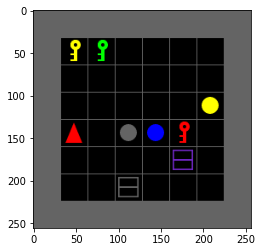

In [7]:
mission, obs, grid, grid_raw, directions, actions, actions_text = demos_valid[0]
print(mission)
plt.imshow(blosc.unpack_array(grid)[0])

In [96]:
img = blosc.unpack_array(grid_raw)[0]
height, width, channel = img.shape

unique_object_counts = defaultdict(int)
for h in range(height):
    for w in range(width):
        unique_object_counts[str(img[h][w])] += 1

In [102]:
def get_impossible_mission(img):
    while True:
        object_id = np.random.choice(OBJECT_IDS, size=1)[0]
        color_id = np.random.choice(COLOR_IDS, size=1)[0]
        object_tuple = [object_id, color_id, 0]

        if not is_object_existing(img, object_tuple):
            return color_id, object_id

In [97]:
while True:
    object_id = np.random.choice(OBJECT_IDS, size=1)[0]
    color_id = np.random.choice(COLOR_IDS, size=1)[0]
    object_tuple = [object_id, color_id, 0]
    
    if not is_object_existing(img, object_tuple):
        print(get_object_name(color_id, object_id))
        break

blue box
